In [1]:
!pip install librosa
import os
from PIL import Image
import librosa
import glob
import time
import numpy as np
import pandas as pd 
import tensorflow as tf
import keras
from sklearn.metrics import roc_curve, auc

Using TensorFlow backend.


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

In [2]:
dataset_path = "/content/drive/My Drive/img.pkl"
res = pd.read_pickle(dataset_path)
x = res.drop(["y"], axis=1)                     
y = res['y']
print(x.shape,y.shape)
max_data = np.max(x)
min_data = np.min(x)
data = (x-min_data)/(max_data-min_data+1e-6)
data =  data-0.5
x = x.to_numpy().reshape(x.shape[0], 128, 44)
# mean = x.mean(axis=2).reshape(52117,1,128) 
# var = x.var(axis=2).reshape(52117,1,128)
# data = x - mean
# data = data / (var+0.1e-16)

print("Normalization done!")
x = data.to_numpy().reshape(data.shape[0],128*44)
y = y.to_numpy()

(52117, 5632) (52117,)
Normalization done!


In [ ]:
d = 128*44
ep = 30
batches = 35

import sys
sys.path.extend(['/home/luca/Scrivania/PyDir/CNN'])
from keras.models import Sequential
from keras.layers import Dense
import numpy as np
import matplotlib.pylab as plt
import pickle
import os
model = Sequential()
model.add(Dense(units=2, activation='relu',input_dim=d))
model.add(Dense(units=3*d, activation='relu'))
model.add(Dense(units=d, activation='sigmoid'))
model.compile(optimizer='adam', loss='mse')

In [4]:
x_train = x[y == 29]
x_train.shape
x_test = x[y != 29]
x_test.shape

(50153, 5632)

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager
from sklearn import svm

# fit the model
clf = svm.OneClassSVM( kernel="poly",cache_size=1000, degree=4)
clf.fit(x_train)
scores = clf.decision_function(np.concatenate([x_train,x_test]))


(52117,) (52117,)


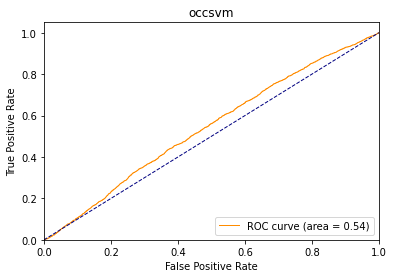

In [12]:
plot_roc_curve("occsvm", 0, scores)

In [ ]:
import pickle
name = "occsvm"
filename = '/content/drive/My Drive/ModelliSalvati/Audio/outlier/'+name+'.sav'
pickle.dump(clf, open(filename, 'wb'))

In [ ]:
y_pred_train = clf.predict(x_train)
y_pred_test = clf.predict(x_test)
n_error_train = y_pred_train[y_pred_train == -1].size
n_error_test = y_pred_test[y_pred_test == -1].size
print(n_error_train,n_error_test)

984 33915


In [ ]:
from sklearn.ensemble import IsolationForest
clf = IsolationForest(random_state=0,n_estimators=1000).fit(x_train)
scores = clf.decision_function(np.concatenate((x_train,x_test)))
import matplotlib.pyplot as plt
plot_roc_curve("isolation_forest", 0, scores)

(52117,) (52117,)


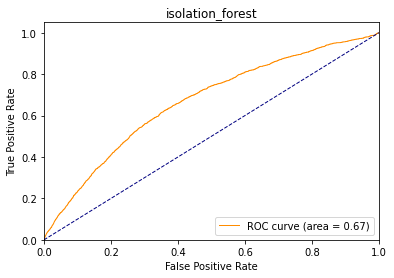

In [ ]:
import pickle
name = "isolationforest"
filename = '/content/drive/My Drive/ModelliSalvati/Audio/outlier/'+name+'.sav'
pickle.dump(clf, open(filename, 'wb'))

In [ ]:
from pyod.models.knn import KNN
import pyod
y_true = np.zeros(x.shape[0])
y_true[x_train.shape[0]:]=1
# train kNN detector
clf_name = 'KNN'
clf = KNN(method='mean',n_neighbors=2)
clf.fit(x_train)

KNN(algorithm='auto', contamination=0.1, leaf_size=30, method='mean',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=2, p=2,
  radius=1.0)

In [ ]:
import pickle
name = "KNN"
filename = '/content/drive/My Drive/ModelliSalvati/Audio/outlier/'+name+'.sav'
pickle.dump(clf, open(filename, 'wb'))

In [ ]:
loaded_model = pickle.load(open(filename, 'rb'))
#result = loaded_model.score_samples(np.concatenate((x_train,x_test),axis=0))
print(loaded_model)

KNN(algorithm='auto', contamination=0.1, leaf_size=30, method='mean',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=2, p=2,
  radius=1.0)


In [ ]:
# get the prediction on the test data
y_test_pred = loaded_model.predict(x_test)  # outlier labels (0 or 1)
y_test_scores = loaded_model.decision_function(x_test)  # outlier scores
clf_name="KNN"

In [ ]:
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # raw outlier scores
pyod.utils.data.evaluate_print(clf_name, y_true, np.concatenate((y_train_scores,y_test_scores)))

KNN ROC:0.793, precision @ rank n:0.967


In [ ]:
y_true

array([0., 0., 0., ..., 1., 1., 1.])

In [8]:
def plot_roc_curve(name, plotted_class, scores):
  y_true = np.ones(x.shape[0])
  y_true[x_train.shape[0]:]=-1
  print(scores.shape,y_true.shape)
  # Compute ROC curve and ROC area for each class
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(2):
      fpr[i], tpr[i], _ = roc_curve(y_true,scores)
      roc_auc[i] = auc(fpr[i], tpr[i])

  # Compute micro-average ROC curve and ROC area
  fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), scores.ravel())
  roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
  plt.figure()
  lw = 1 
  plt.plot(fpr[plotted_class], tpr[plotted_class], color='darkorange',
          lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[plotted_class])
  plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(name)
  plt.legend(loc="lower right")
  plt.show()
plot_roc_curve("occsvm",0,scores)

NameError: ignored

In [ ]:
scores = clf.decision_function(x)

In [ ]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_true,scores)

[ -9.80092773 -10.76964818  -9.35127028 ...  -4.72478558  -5.96064597
  -6.28924804]


0.4446175355144419

In [ ]:
history = model.fit(x_train, x_train, epochs=ep, batch_size=batches, validation_data = (x_test, x_test));
history_dict = history.history;
with open('anomaly.hist','wb') as hist_file:
  pickle.dump(history_dict, hist_file);
model.save_weights('anomaly');

In [ ]:
test_size = x_test.shape[0]
outlierness = np.zeros(test_size)

for i in range(test_size):
    outlierness[i] = model.evaluate(x_test[i].reshape((1,d)),x_test[i].reshape((1,d)),verbose=0)

plt.figure(1)
plt.plot(outlierness,'.')
plt.xlabel('test id')
plt.ylabel('outlierness')
plt.figure(2)
x = np.linalg.norm(x_test,axis=1)
plt.plot(x,outlierness,'.')
plt.xlabel('norm')
plt.ylabel('outlierness')

In [6]:

def plot_roc_curve(name, plotted_class, scores):
  y_true = np.ones(x.shape[0])
  y_true[x_train.shape[0]:]=-1
  print(scores.shape,y_true.shape)
  # Compute ROC curve and ROC area for each class
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(2):
      fpr[i], tpr[i], _ = roc_curve(y_true,scores)
      roc_auc[i] = auc(fpr[i], tpr[i])

  # Compute micro-average ROC curve and ROC area
  fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), scores.ravel())
  roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
  plt.figure()
  lw = 1 
  plt.plot(fpr[plotted_class], tpr[plotted_class], color='darkorange',
          lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[plotted_class])
  plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(name)
  plt.legend(loc="lower right")
  plt.show()